# Real Data Analyses

In this section, we will explore applying spectral parameterization to a real dataset.

The data is from anesthesia, including a waking data segment, a low-dose propofol segment, and a high-dose propofol segment. See the data folder for more information on the data. 

The main goal here is to explore the real data, and use spectral parameterization to come to some conclusions about what is happening in the data, and what is changing between conditions. 

There are some prompts in this notebook to guide you towards some analyses you can apply. That said, these are meant as something of a starting point - you are encouraged to go beyond the prompts and to continue to explore this data.

In [1]:
import os
from pathlib import Path

from scipy.io import loadmat

# Import fooof functions
from fooof import FOOOF
from fooof.plts import plot_spectrum
from fooof.analysis import get_band_peak_fm

# Import neurodsp functions
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

## Load the Data

First, we will load some data. This section is filled in for you. 

In [2]:
# Define the data path
data_path = Path('../data')

In [3]:
# Get available data files
data_files_lst = [file for file in os.listdir(data_path) if '.mat' in file]
data_files_lst

['eeganes07laplac250_detrend_all_t180.mat',
 'eeganes07laplac250_detrend_all_t4710.mat',
 'eeganes07laplac250_detrend_all_t3070.mat']

### Data Information

EEG data from a healthy subject during propofol‑induced unconsciousness:
-  `eeganes07laplac250_detrend_all_t180.mat` Awake, before propofol induction
-  `eeganes07laplac250_detrend_all_t3070.mat` Unconscious, at a low dose of propofol
-  `eeganes07laplac250_detrend_all_t4710.mat` Unconscious, at a high dose of propofol

In [4]:
# Get list of data file names, and store in a labelled dictionary
data_files_lst.sort()
data_files = {
    'awake' : data_files_lst[0],
    'low_dose' : data_files_lst[1],
    'high_dose' : data_files_lst[2],
}

### Load a Data File

To start, we will load a specific file to explore. 

If you want to switch which file you explore, change the 'condition' value below. 

In [5]:
# Set which data file to load (change here to run another file)
condition = 'awake'   # 'awake', 'low_dose', 'high_dose'

In [6]:
# Load a matfile with the data
matfile = loadmat(data_path / data_files[condition], squeeze_me=True)

In [7]:
# Check the data keys that are the matfile
matfile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'egrid_0indexed', 'ta', 'y'])

In [8]:
# Extract data fields of interest
data = matfile['y'].T        # Data matrix - transpose to have channels as rows
fs = matfile['Fs']           # Sampling rate
times = matfile['ta']        # Times vector

In [9]:
# For simplicity, reset times vector to go from 0 to 30
times = times - times[0]

### Extract channel of interest

To get started, we will choose a particular channel to examine. 

Channels 40 & 41 are frontal channels that are good channels to explore first, as they display features of interest and clear changes across the different brain states we have available. You should start with these channels - but feel free to explore other channels after. 

In [10]:
# Define channel index of interest
chind = 41  # 40, 41

In [11]:
# Extract channel data of interest
channel_data = data[chind, :]

## Data Explorations & Analyses

In this section, we will now start looking at and exploring / analyzing the data. 

From here, you need to start filling in code!

Note that to complete the prompts that are defined, you should not have to import any additional functions - however, you are more than welcome to import additional tools in order to extend the analyses. 

### Look at the time series

First, let's visualize the time series. 

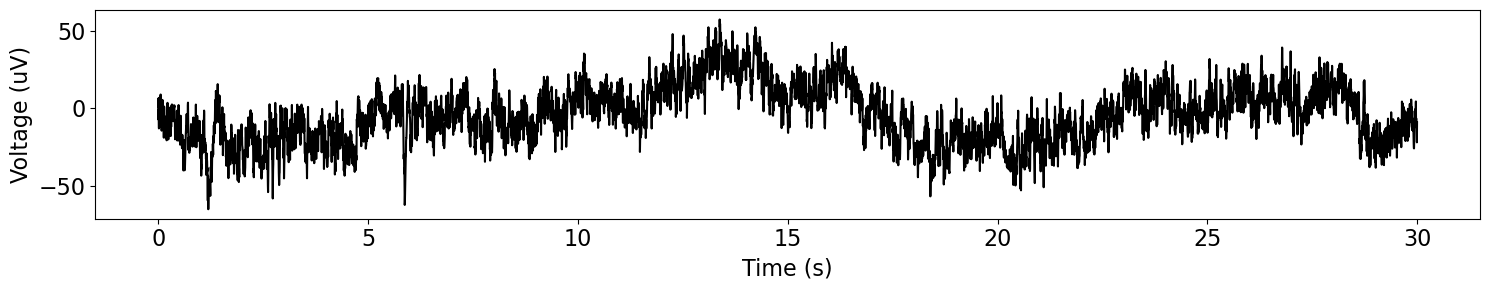

In [12]:
# Plot the time series 
plot_time_series(times, channel_data)

### Compute power spectrum

Next, let's compute a power spectra.

In [13]:
# Define settings for estimating the power spectrum
psd_settings = {
    'nperseg' : 2 * fs, 
    'noverlap' : fs,
    'f_range' : [1, 100],
}

In [14]:
# Compute power spectrum
freqs, powers = compute_spectrum(channel_data, fs, **psd_settings)

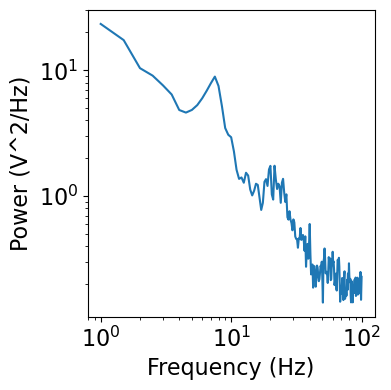

In [15]:
# Visualize power spectrum
plot_power_spectra(freqs, powers, figsize=(4, 4))

### Parameterize the Spectrum

Next, let's fit a spectral model to the power spectrum we just computed.

In [16]:
# Initialize spectral model
fm = FOOOF(peak_width_limits=[2, 8])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.3900, 1.1314                                          
                                                                                                  
                                       4 peaks were found:                                        
          

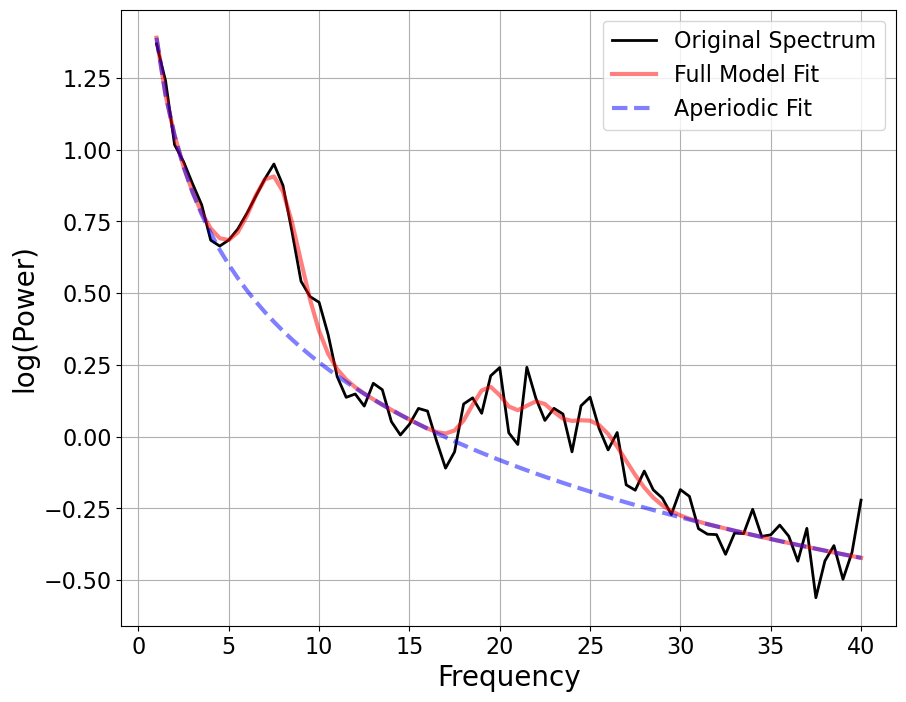

In [17]:
# Fit spectral model to the data
fm.report(freqs, powers, freq_range=[1, 40])

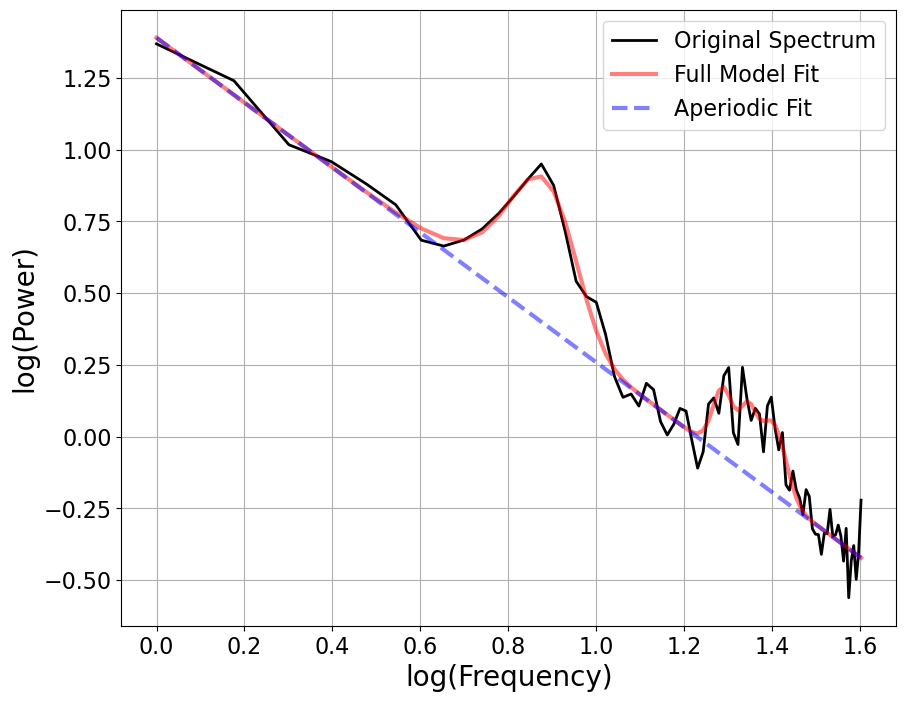

In [18]:
# Check the spectral model in log-log spacing
fm.plot(plt_log=True)

#### Explore parameters

Now that we have a spectral model, explore the parameters that it fit. 

In particular, make sure to 

In [19]:
# Extract the dominant low frequency peak
peak = get_band_peak_fm(fm, [1, 20])
cf, pw, bw = peak
cf, pw, bw

(7.591941784028051, 0.506663077817998, 2.748383493691047)

### Filter to the peak range

Next, let's explore the rhythm in the data. 

Filter the data around the frequency range of dominant peak (for example, +/- bandwidth around peak center frequency). 

In [20]:
# Create a mildly filtered / broadband version of the channel data
broadband = filter_signal(channel_data, fs, 'bandpass', [0.5, 100], remove_edges=False)

In [21]:
# Filter the signal to narrowband range
narrowband = filter_signal(channel_data, fs, 'bandpass', [cf-3, cf+3])

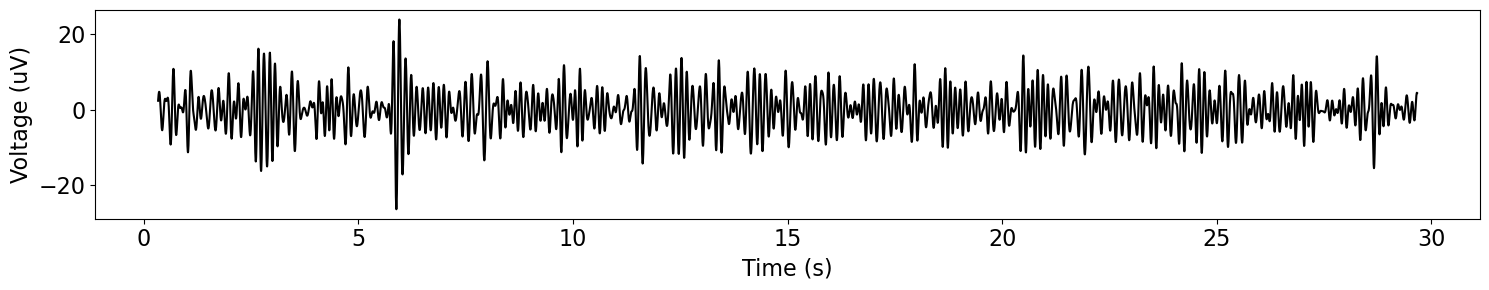

In [22]:
# Visualize the narrowband filtered signal
plot_time_series(times, narrowband)

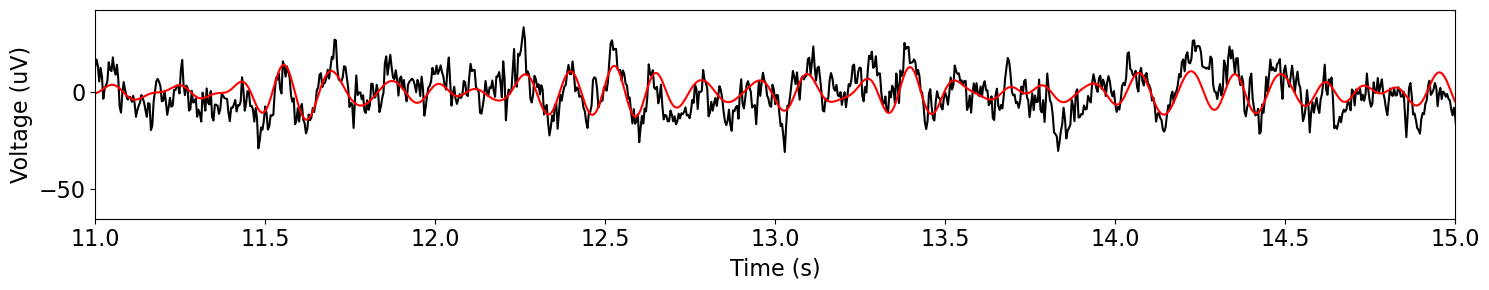

In [23]:
# Plot the filtered trace on top of the original data
plot_time_series(times, [broadband, narrowband], xlim=[11, 15])

In the above, we used sepctral parameterization to identify a peak of interest, and then examine this in the data. 

What does it look like when we do so:
- Is peak frequency as identified by spectral parameterization clearly present in the time series?
- If so, is the rhythm continuous / ongoing? Is it sinusoidal?
- If you answer no to either question above, what does this mean about how we should interpret / further analyze the data?

## Compare Data Across Brain States

Next, we will explore and compare the data across the different brain states.

Things you should try:
- Load and plot the time series for each state, to visually compare them
- Compute the power spectra across states, to visually compare them
- Fit spectral models across each state
- Compare the fit parameters, examing which parameters change across the different brain states

In [24]:
# Check the available data files
data_files 

{'awake': 'eeganes07laplac250_detrend_all_t180.mat',
 'low_dose': 'eeganes07laplac250_detrend_all_t3070.mat',
 'high_dose': 'eeganes07laplac250_detrend_all_t4710.mat'}

In [25]:
# Initialize some empty dictionaries to store data & measures of interest
timeseries = {}
spectra = {}
models = {}

In [26]:
# Loop across data files, extracting data and computing measures of interest
for label, cond_file in data_files.items():
    
    # Load data files & get channel file
    temp_data = loadmat(data_path / cond_file, squeeze_me=True)
    
    # Collect time series
    temp_timeseries = temp_data['y'].T[chind, :]
    timeseries[label] = temp_timeseries
        
    # Compute power spectrum
    _, cond_powers = compute_spectrum(temp_timeseries, fs, **psd_settings)
    spectra[label] = cond_powers
    
    # Fit spectral model and 
    fm.fit(freqs, cond_powers)
    models[label] = fm.copy()

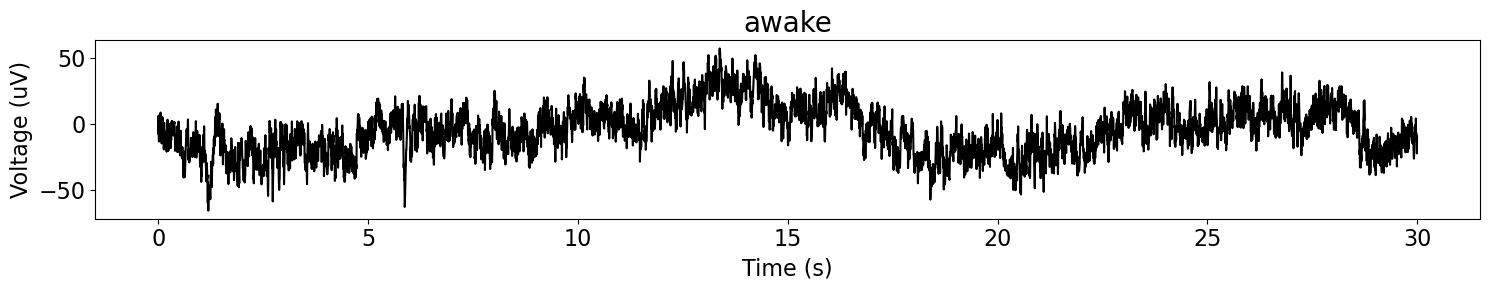

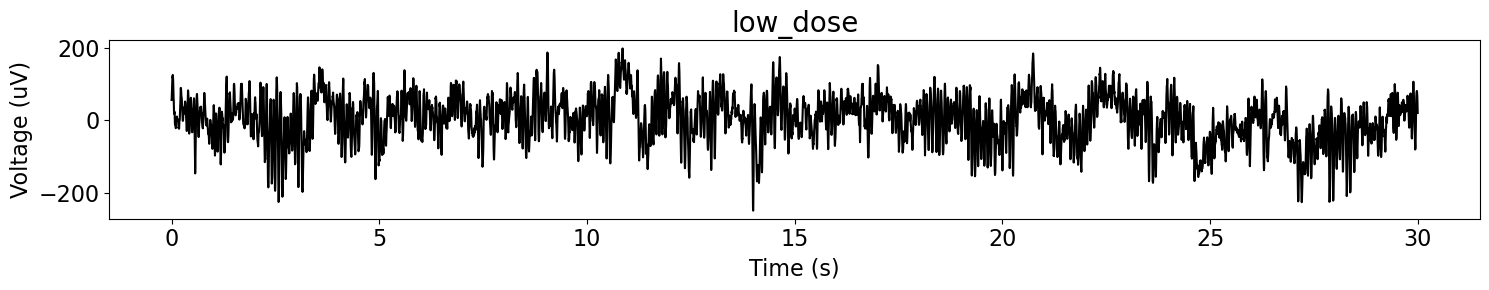

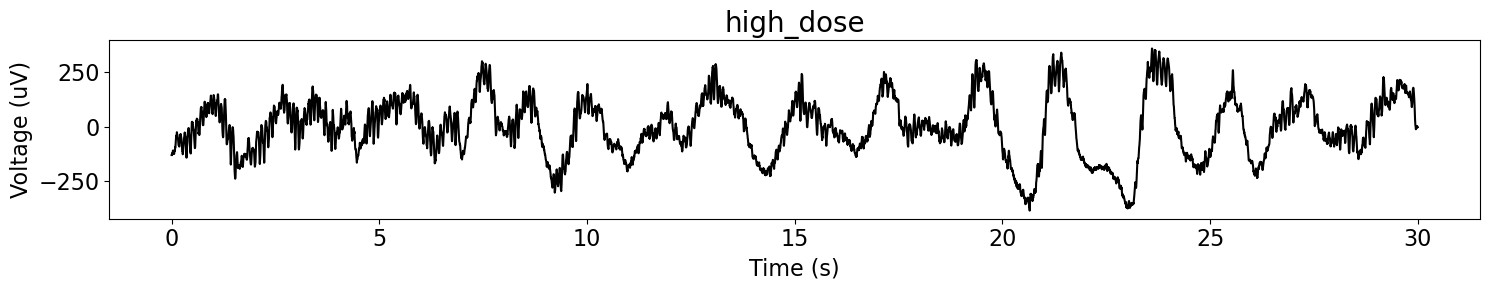

In [27]:
# Visualize the time series across each stage
xlim = None  # add limit to : interesting range - [18, 27]
for label, tdata in timeseries.items():
    plot_time_series(times, tdata, title=label, xlim=xlim)

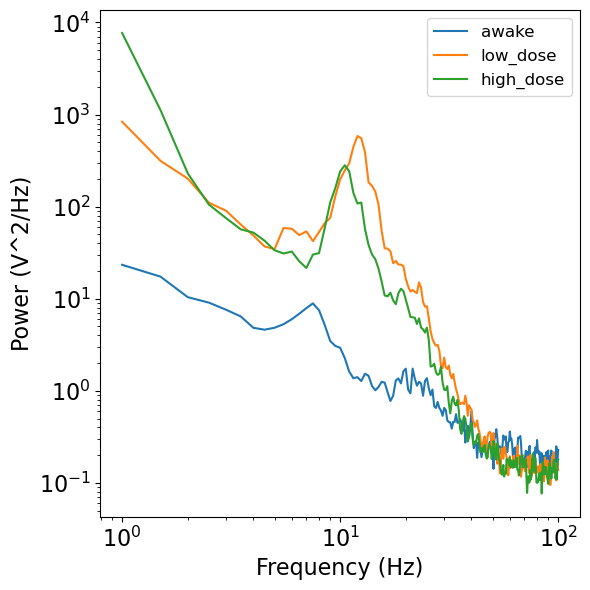

In [28]:
# Visualize the power spectra across each stage
plot_power_spectra(freqs, list(spectra.values()), labels=list(spectra.keys()))

In [29]:
# Check the aperiodic parameters across brain state
print('Aperiodic Exponents:')
for label, cfm in models.items():
    print('\t{:10s} \t {:2.4f}'.format(label, cfm.get_params('aperiodic', 'exponent')))

Aperiodic Exponents:
	awake      	 1.1874
	low_dose   	 2.0950
	high_dose  	 2.2225


In [30]:
# Check the periodic parameters across brain state
print('Dominant Peak \t\t CF \t\t PW \t\t BW')
for label, cfm in models.items():
    print('\t{:10s} \t {:2.4f} \t {:2.4f} \t {:2.4f}'.format(label, *get_band_peak_fm(cfm, [1, 20])))

Dominant Peak 		 CF 		 PW 		 BW
	awake      	 7.6243 	 0.5161 	 2.8607
	low_dose   	 12.4264 	 1.8617 	 5.5998
	high_dose  	 10.1563 	 1.4516 	 2.8107


## Conclusions

What have we learned about this dataset from using spectral parameterization?

Are there more aspects of the data we may want to investigate, that spectral parameterization does not do?